In [1]:
from scipy import io as scipy_io
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.utils import io as ipy_io
import sys
import re


data_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/lidarmodeling_202404'
output_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Lidar Simulation/output_008/'

data_version = '008'

redwood_file = 'rw_alltreeinfo.mat'
guiana_file = 'fg_alltreeinfo.mat'

redwood_filepath = os.path.normpath(os.path.join(data_path, 'RW' + data_version, redwood_file))
guiana_filepath = os.path.normpath(os.path.join(data_path, 'FG' + data_version, guiana_file))

redwood_mat_data = scipy_io.loadmat(redwood_filepath)
guiana_mat_data = scipy_io.loadmat(guiana_filepath)

radius = 33.3 / 2

# Leaf Density ratio
redwood_leaf_density_ratio = 2500  # Leaves per m3
guiana_leaf_density_ratio = 8750  # Leaves per m3

In [2]:
def circle_intersection_percentage(x1, y1, r1, x2, y2, r2):
    # Calculate the area of the first circle
    area1 = math.pi * r1**2
    
    # Calculate the distance between the centers of the circles
    d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Check if the circles are separate or one is completely inside the other
    if d >= r1 + r2:
        # Circles are separate, no intersection
        return 0
    elif d <= abs(r1 - r2) and r1 >= r2:
        # Circle 2 is completely inside circle 1, intersection area is area of circle 2
        return math.pi * r2**2 / area1 * 100
    elif d <= abs(r1 - r2) and r1 < r2:
        # Circle 1 is completely inside circle 2, intersection area is area of circle 1
        return 100
    else:
        # Calculate the intersection area using the formula for the area of a circular segment
        A = r1**2 * math.acos((d**2 + r1**2 - r2**2) / (2 * d * r1)) + r2**2 * math.acos((d**2 + r2**2 - r1**2) / (2 * d * r2)) - 0.5 * math.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return A / area1 * 100
    
def load_matlab(region):
    if region == 'redwood':
        tree_elements = redwood_mat_data['tree'][0]
        x_values = redwood_mat_data['tree_x'][0]
        y_values = redwood_mat_data['tree_y'][0]
    elif region == 'guiana':
        tree_elements = guiana_mat_data['tree'][0]
        x_values = guiana_mat_data['tree_x'][0]
        y_values = guiana_mat_data['tree_y'][0]
    else:
        raise ValueError("Invalid region. Please specify either 'redwood' or 'guiana'.")

    return tree_elements, x_values, y_values

def declare_tree_and_circle_data(tree_elements):
    tree_data = {f'Tree [{i}]': {'crown_base': 0, 
                        'crown_d1': 0, 'crown_d2': 0, 'crown_d3': 0,
                        'crown_center_height': 0, 'tree_height': 0, 
                        'crown_base_height': 0,
                        'crown_volume': 0, 'single_leaf_area': 0, 
                        'total_leaf_area': 0, 'total_tree_branch_area': 0,
                        'total_tree_stem_area': 0, 'total_tree_ground_area': 0, 
                        'total_tree_canopy_veg_area': 0,
                        'x_coord': 0, 'y_coord': 0
                        } 
                        for i in range(1, len(tree_elements) + 1)}

    circle_data = {f'Circle [{i}, {j}]': {'tree_indices': [], 'crown_vol_in_circle': [], 
                        'crown_percentages': [], 'tree_heights': [],
                        'tree_density': 0, 'tree_percent_total': 0,
                        'mean_crown_d1': 0, 'std_crown_d1': 0, 'mean_crown_d2': 0,
                        'std_crown_d2': 0, 'mean_crown_center_height': 0, 
                        'std_crown_center_height': 0, 'mean_tree_height': 0,
                        'std_tree_height': 0, 'single_leaf_areas': [],
                        'adj_branch_areas': [], 'adj_leaf_areas': [],
                        'total_tree_canopy_veg_area': [], 'total_leaf_veg_area': 0,
                        'mean_crown_volume': 0, 'std_crown_volume': 0,
                        'total_crown_volume': 0, 'adj_crown_volume': 0,
                        'pixel_area': 0, 'total_vegetation_area_per_pixel': 0,
                        'LAI_with_branch': 0, 'LAI_without_branch': 0,
                        'h1': 0, 'h2': 0, 'Fa': 0, 'Fa_b': 0
                        }
                        for i in range(3, 0, -1) for j in range(1, 4)}
    
    return tree_data, circle_data

def calc_basic_tree_info(tree_index, tree_element, tree_data, redwood_x_values, redwood_y_values):

    # Extract base, d1, d2, d3 value from tree crown
    base = tree_element[0][0][0][0][0][0]
    d1 = tree_element[0][0][0][1][0][0]
    d2 = tree_element[0][0][0][2][0][0]
    d3 = tree_element[0][0][0][3][0][0]

    # Calculate the volume of the tree spheroid
    crown_volume = (4/3) * math.pi * d2**2 * d1
    # Calculate the Crown Center Height for each tree in the circle
    crown_center_height = base + (d3 / 2)
    # Calculate the Crown Base height
    crown_base_height = crown_center_height - d1
    # Calculate the Tree Height for each tree in the circle
    tree_height = base + d1 + (d3 / 2)
    # Calculate total ground area, just the area of circle with crown_radius d1
    total_tree_ground_areas = math.pi * d1**2

    # Extract leaf number, leaf width, tree leaf, calculate leaf area, then total leaf area
    single_leaf_length = tree_element[5][0][0][1][0][0]
    single_leaf_width = tree_element[5][0][0][2][0][0]
    single_leaf_area = single_leaf_length * 2 * single_leaf_width

    total_leaf_area = single_leaf_area * redwood_leaf_density_ratio * crown_volume

    # Add basic info to each tree
    tree_data[f'Tree [{tree_index}]']['crown_base'] = base
    tree_data[f'Tree [{tree_index}]']['crown_d1'] = d1
    tree_data[f'Tree [{tree_index}]']['crown_d2'] = d2
    tree_data[f'Tree [{tree_index}]']['crown_d3'] = d3

    tree_data[f"Tree [{tree_index}]"]['crown_volume'] = crown_volume
    tree_data[f"Tree [{tree_index}]"]['crown_center_height'] = crown_center_height
    tree_data[f"Tree [{tree_index}]"]['crown_base_height'] = crown_base_height
    tree_data[f"Tree [{tree_index}]"]['tree_height'] = tree_height
    tree_data[f"Tree [{tree_index}]"]['total_tree_ground_area'] = total_tree_ground_areas

    tree_data[f'Tree [{tree_index}]']['single_leaf_area'] = single_leaf_area
    tree_data[f"Tree [{tree_index}]"]['total_leaf_area'] = total_leaf_area

    total_branch_area = calc_basic_branch_info(tree_element)
    tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] = total_branch_area

    tree_total_canopy_veg_areas = total_leaf_area + total_branch_area
    tree_data[f"Tree [{tree_index}]"]['total_tree_canopy_veg_area'] = tree_total_canopy_veg_areas

    # Assign x and y coordinates
    tree_data[f'Tree [{tree_index}]']['x_coord'] = redwood_x_values[tree_index - 1]  # Adjusting for 1-based indexing
    tree_data[f'Tree [{tree_index}]']['y_coord'] = redwood_y_values[tree_index - 1]

    return d2, crown_volume

def calc_basic_branch_info(tree_element):

    # Initial values for total primary, secondary, and tertiary branch areas
    total_prim_branch_area = 0
    total_sec_branch_area = 0
    total_tert_branch_area = 0

    # For each tree, iterate through each primary branch array to get the total primary branch area
    for prim_branch_index in range(len(tree_element[2][0][0][0][0])):
        prim_branch_length = tree_element[2][0][0][0][0][prim_branch_index]
        prim_branch_radius = tree_element[2][0][0][1][0][prim_branch_index]
        prim_branch_area = 2 * prim_branch_radius * prim_branch_length
        total_prim_branch_area = total_prim_branch_area + prim_branch_area

    # for each tree, iterate through each secondary branch array to get the total secondary branch area
    for sec_branch_index in range(len(tree_element[3][0][0][0][0])):
        sec_branch_length = tree_element[3][0][0][0][0][sec_branch_index]
        sec_branch_radius = tree_element[3][0][0][1][0][sec_branch_index]
        sec_branch_area = 2 * sec_branch_radius * sec_branch_length
        total_sec_branch_area = total_sec_branch_area + sec_branch_area    
    
    # for each tree, iterate through each tertiary branch array to get the total tertiary branch area
    for tert_branch_index in range(len(tree_element[4][0][0][0][0])):
        tert_branch_length = tree_element[4][0][0][0][0][tert_branch_index]
        tert_branch_radius = tree_element[4][0][0][1][0][tert_branch_index]
        tert_branch_area = 2 * tert_branch_radius * tert_branch_length
        total_tert_branch_area = total_tert_branch_area + tert_branch_area

    total_branch_area = total_prim_branch_area + total_sec_branch_area + total_tert_branch_area
    return(total_branch_area)

def find_tree_in_circle(d2, crown_volume, tree_index, x, y, circle_indices):

    # Flag to indicate whether the point falls within a circle
    circle_within_grid = False

    # Check each circle in the 3x3 grid
    for i in range(3, 0, -1):
        for j in range(1, 4):
            # Calculate the center of the current circle
            center_x = (j-2) * 2 * radius
            center_y = (i-2) * 2 * radius
            
            # Calculate distance from the center of the current circle
            dist = math.sqrt((center_x - x)**2 + (center_y - y)**2)
            
            # Check if the distance is less than or equal to the radius
            if dist <= radius + d2:
                print(f'Tree {tree_index} at {x}, {y} found in: [{i}, {j}]')

                # Calculate the volume of the intersection between the tree and the circle
                intersection_percentage = circle_intersection_percentage(x, y, d2, center_x, center_y, radius) / 100
                intersection_volume = crown_volume * intersection_percentage
                print(f'\tTree {tree_index} crown volume is: {crown_volume}')
                print(f'\tTree {tree_index} intersection percentage with Circle [{i}, {j}] is: {intersection_percentage}')
                print(f'\tApprox. Tree {tree_index} intersection volume with Circle [{i}, {j}] is: {intersection_volume}\n')

                # Add the tree values to the corresponding circle's list
                circle_name = f'Circle [{i}, {j}]'
                circle_data = circle_indices[circle_name]
                circle_data['tree_indices'].append(tree_index)

                # Add intersection volume to the 'crown_vol_in_circle' field
                circle_indices[circle_name]['crown_percentages'].append(intersection_percentage)
                circle_indices[circle_name]['crown_vol_in_circle'].append(intersection_volume)

                circle_within_grid = True  # Set flag to True

    # If the tree is not found within any circle, print the message
    if not circle_within_grid:
        print(f'Tree {tree_index} at {x}, {y} with radius {d2} not found within any grid circle!\n')

In [3]:
def plot_trees(x_values, y_values, tree_elements, region):
    # Set the figure size
    plt.figure(figsize=(20, 20))

    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 15

    # Create a scatter plot for each tree
    for index, (x, y, tree_element) in enumerate(zip(x_values, y_values, tree_elements), start=1):
        # Extract d2 value from tree crown
        d2 = tree_element[0][0][0][2][0][0]
        plt.scatter(x, y, color='black', marker='o')  # Black dot for tree
        
        # Draw green circle around the tree with radius equal to d2
        circle = plt.Circle((x, y), d2, color='green', fill=False, linestyle='--', linewidth=1.5)
        plt.gca().add_artist(circle)

        # Add text label for the tree index slightly below the point
        plt.text(x, y - 1.5, str(index), ha='center', va='center', fontsize=12)  # Adjust fontsize and offset as needed

    # Plot the circles and label them
    for i in range(3, 0, -1):
        for j in range(1, 4):
            center_x = (j - 2) * 2 * radius
            center_y = (i - 2) * 2 * radius
            circle = plt.Circle((center_x, center_y), radius, color='red', fill=False)
            plt.gca().add_artist(circle)
            plt.text(center_x, center_y, f'[{i}, {j}]', ha='center', va='center', fontsize=12, color='red')  # Adjust fontsize as needed

    # Add labels, title, etc. if required
    plt.xlabel('X')
    plt.ylabel('Y')
    if (region == 'redwood'):
        plt.title('Scatter Plot of Trees with Circle Plots \n(with 33.3m diameter) in California Redwoods')
    if (region == 'guiana'):
        plt.title('Scatter Plot of Trees with Circle Plots \n(with 33.3m diameter) in French Guiana')

    # Set equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    plt.savefig(output_path + region + '_trees_plots.png')
    
    # Show the plot
    plt.show()

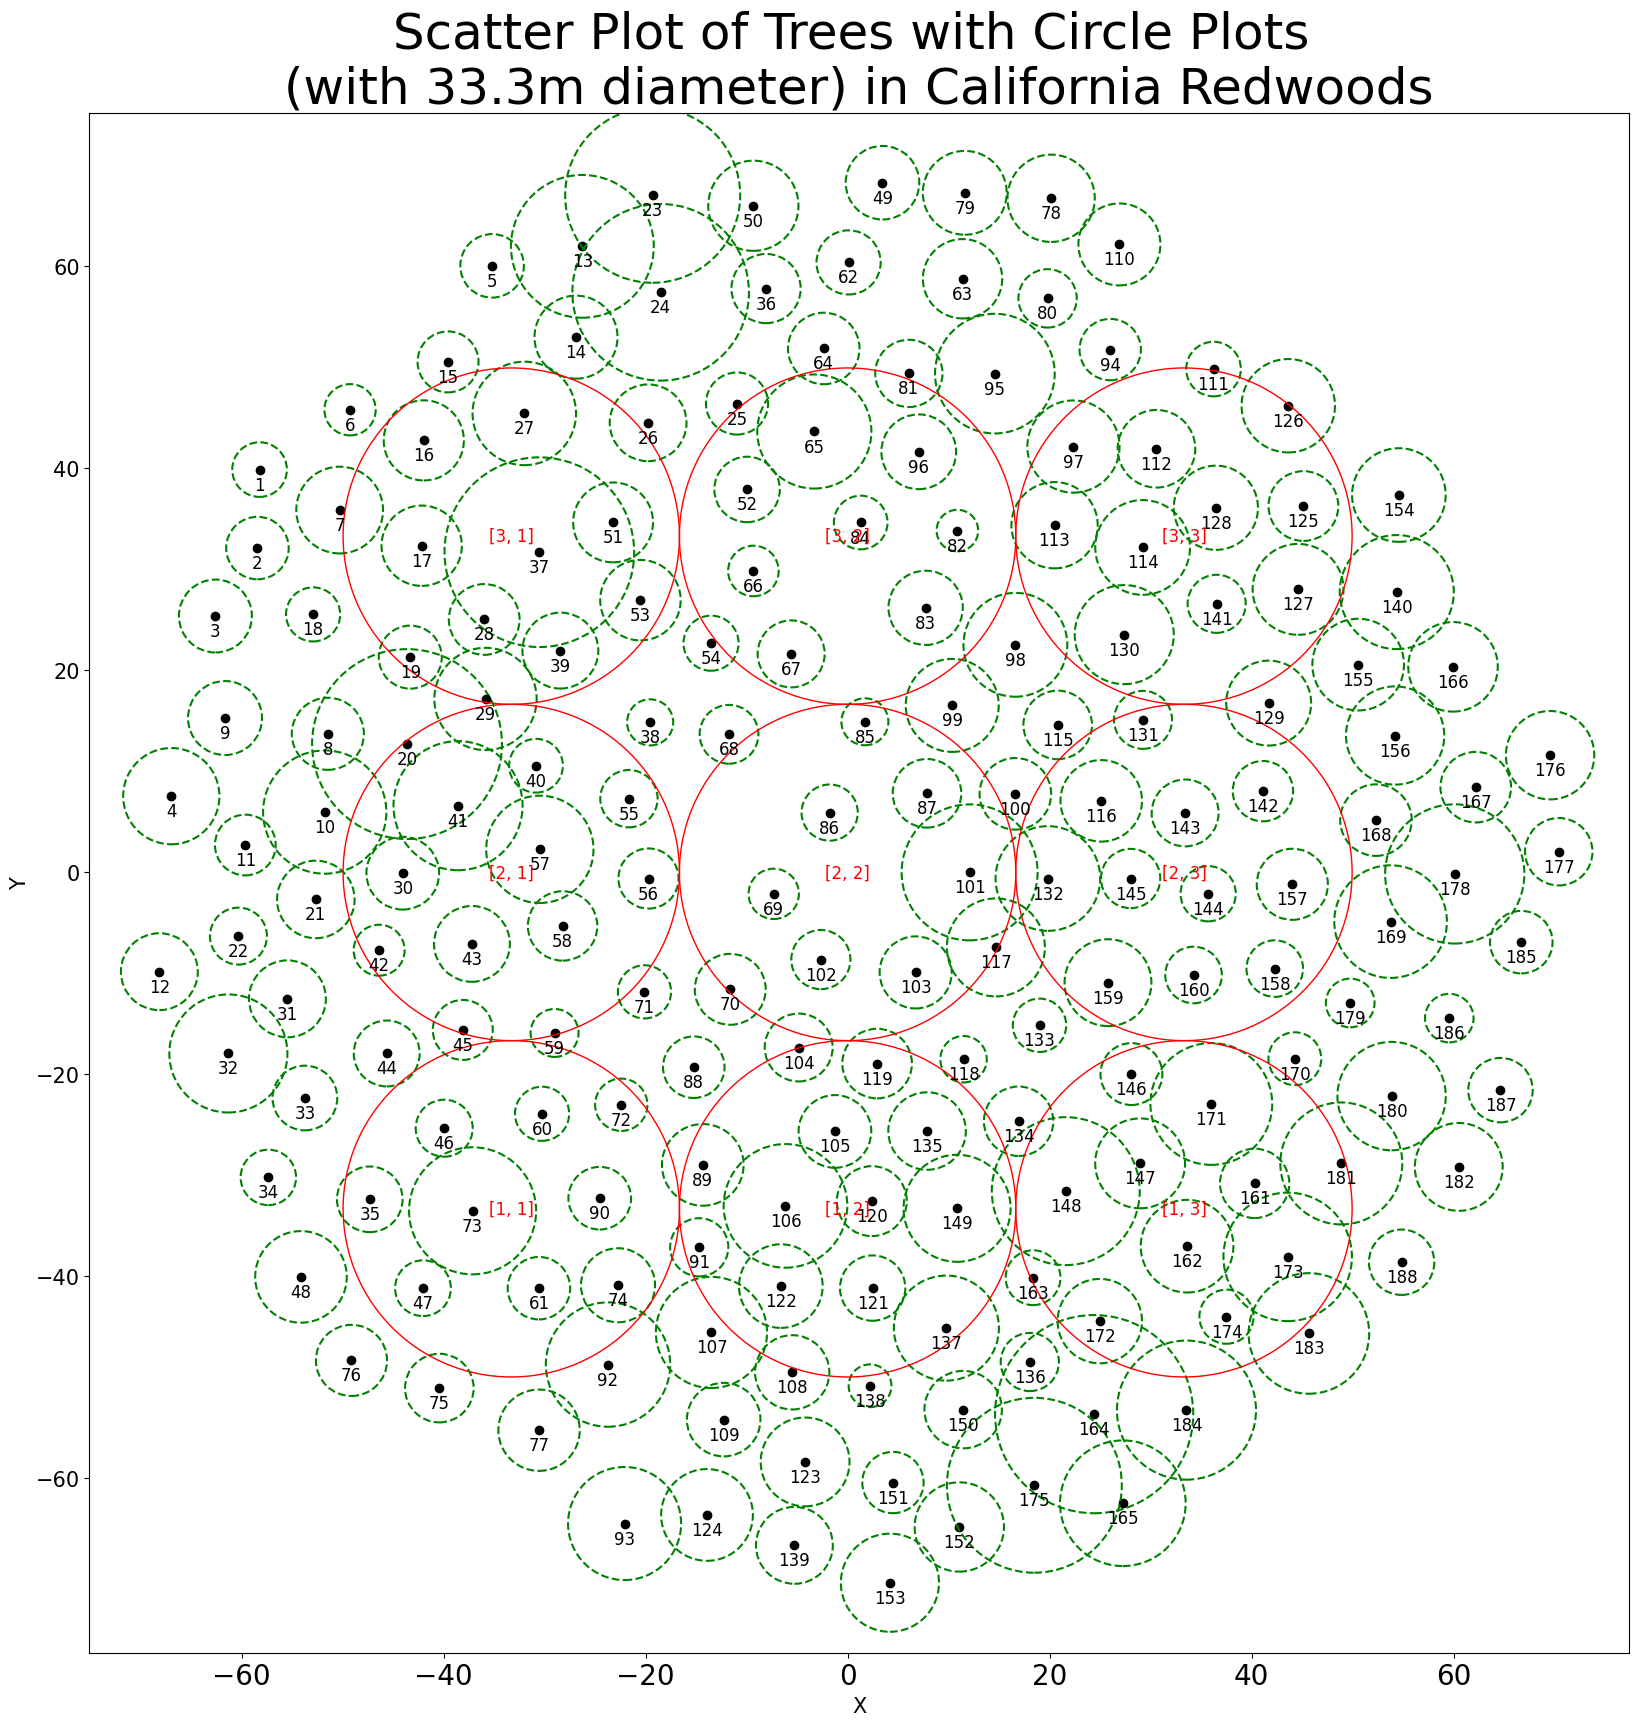

In [4]:
# Redirecting stdout to a text file
output_file = output_path + 'redwood_tree_search_output.txt'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

region = 'redwood'

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    redwood_tree_elements, redwood_x_values, redwood_y_values = load_matlab(region)
    redwood_tree_data, redwood_circle_indices = declare_tree_and_circle_data(redwood_tree_elements)

    total_trees = len(redwood_x_values)

    for tree_index, (x, y, tree_element) in enumerate(zip(redwood_x_values, redwood_y_values, redwood_tree_elements), start=1):

        print(f"Processing tree {tree_index} of {total_trees}")

        d2, crown_volume = calc_basic_tree_info(tree_index, tree_element, redwood_tree_data, redwood_x_values, redwood_y_values)

        find_tree_in_circle(d2, crown_volume, tree_index, x, y, redwood_circle_indices)

with open(output_file, "w") as file:
    file.write(captured_output.stdout)

plot_trees(redwood_x_values, redwood_y_values, redwood_tree_elements, region)

In [5]:
# Assuming tree_data is a dictionary containing tree information
for tree_index, tree_info in redwood_tree_data.items():
    x_coord = tree_info.get('x_coord')
    y_coord = tree_info.get('y_coord')
    if x_coord is not None and y_coord is not None:
        print(f"Tree {tree_index}: x = {x_coord}, y = {y_coord}")
    else:
        print(f"Tree {tree_index}: No coordinates found")

Tree Tree [1]: x = -58.22, y = 39.89
Tree Tree [2]: x = -58.43, y = 32.12
Tree Tree [3]: x = -62.59, y = 25.39
Tree Tree [4]: x = -66.96, y = 7.555
Tree Tree [5]: x = -35.2, y = 60.06
Tree Tree [6]: x = -49.26, y = 45.81
Tree Tree [7]: x = -50.29, y = 35.88
Tree Tree [8]: x = -51.46, y = 13.73
Tree Tree [9]: x = -61.64, y = 15.29
Tree Tree [10]: x = -51.77, y = 5.978
Tree Tree [11]: x = -59.63, y = 2.718
Tree Tree [12]: x = -68.14, y = -9.824
Tree Tree [13]: x = -26.26, y = 61.99
Tree Tree [14]: x = -26.89, y = 53.0
Tree Tree [15]: x = -39.56, y = 50.55
Tree Tree [16]: x = -41.96, y = 42.78
Tree Tree [17]: x = -42.17, y = 32.35
Tree Tree [18]: x = -52.92, y = 25.55
Tree Tree [19]: x = -43.3, y = 21.32
Tree Tree [20]: x = -43.62, y = 12.71
Tree Tree [21]: x = -52.65, y = -2.669
Tree Tree [22]: x = -60.31, y = -6.3
Tree Tree [23]: x = -19.3, y = 67.05
Tree Tree [24]: x = -18.51, y = 57.44
Tree Tree [25]: x = -10.95, y = 46.43
Tree Tree [26]: x = -19.75, y = 44.52
Tree Tree [27]: x = -32.

In [6]:

for tree_index, (x, y, tree_element) in enumerate(zip(redwood_x_values, redwood_y_values, redwood_tree_elements), start=1):
    print(f'\tTree {tree_index} at {x}, {y}: crown_base value: {redwood_tree_data[f'Tree [{tree_index}]']['crown_base']}')
    print(f'\tTree {tree_index} at {x}, {y}: crown_d1 value: {redwood_tree_data[f'Tree [{tree_index}]']['crown_d1']}')
    print(f'\tTree {tree_index} at {x}, {y}: crown_d2 value: {redwood_tree_data[f'Tree [{tree_index}]']['crown_d2']}')
    print(f'\tTree {tree_index} at {x}, {y}: crown_d3 value: {redwood_tree_data[f'Tree [{tree_index}]']['crown_d3']}')
    print(f'\tTree {tree_index} at {x}, {y}: crown_volume: {redwood_tree_data[f'Tree [{tree_index}]']['crown_volume']}')
    print(f'\tTree {tree_index} at {x}, {y}: crown_center_height: {redwood_tree_data[f'Tree [{tree_index}]']['crown_center_height']}')
    print(f'\tTree {tree_index} at {x}, {y}: crown_base_height: {redwood_tree_data[f'Tree [{tree_index}]']['crown_base_height']}')
    print(f'\tTree {tree_index} at {x}, {y}: tree_height: {redwood_tree_data[f'Tree [{tree_index}]']['tree_height']}')
    print(f'\tTree {tree_index} at {x}, {y}: total_tree_ground_area: {redwood_tree_data[f'Tree [{tree_index}]']['total_tree_ground_area']}')
    print(f'\tTree {tree_index} at {x}, {y}: single_leaf_area: {redwood_tree_data[f'Tree [{tree_index}]']['single_leaf_area']}')
    print(f'\tTree {tree_index} at {x}, {y}: total_leaf_area: {redwood_tree_data[f'Tree [{tree_index}]']['total_leaf_area']}')
    print(f'\tTree {tree_index} at {x}, {y}: total_tree_branch_area: {redwood_tree_data[f'Tree [{tree_index}]']['total_tree_branch_area']}')
    print(f'\tTree {tree_index} at {x}, {y}: total_tree_canopy_veg_area: {redwood_tree_data[f'Tree [{tree_index}]']['total_tree_canopy_veg_area']}\n')

	Tree 1 at -58.22, 39.89: crown_base value: 6.53279
	Tree 1 at -58.22, 39.89: crown_d1 value: 4.75503
	Tree 1 at -58.22, 39.89: crown_d2 value: 2.70483
	Tree 1 at -58.22, 39.89: crown_d3 value: 9.46251
	Tree 1 at -58.22, 39.89: crown_volume: 145.72089163029327
	Tree 1 at -58.22, 39.89: crown_center_height: 11.264045
	Tree 1 at -58.22, 39.89: crown_base_height: 6.509015
	Tree 1 at -58.22, 39.89: tree_height: 16.019075
	Tree 1 at -58.22, 39.89: total_tree_ground_area: 71.03238473669306
	Tree 1 at -58.22, 39.89: single_leaf_area: 6e-05
	Tree 1 at -58.22, 39.89: total_leaf_area: 21.858133744543988
	Tree 1 at -58.22, 39.89: total_tree_branch_area: 509.1073367371114
	Tree 1 at -58.22, 39.89: total_tree_canopy_veg_area: 530.9654704816554

	Tree 2 at -58.43, 32.12: crown_base value: 7.02676
	Tree 2 at -58.43, 32.12: crown_d1 value: 5.83397
	Tree 2 at -58.43, 32.12: crown_d2 value: 3.09267
	Tree 2 at -58.43, 32.12: crown_d3 value: 11.6096
	Tree 2 at -58.43, 32.12: crown_volume: 233.732962642793

In [7]:
def get_circle_derived_values(data, tree_indices, tree_data):

    # Initialize lists to store values for the current circle
    d1_values = [tree_data[f'Tree [{tree_index}]']['crown_d1'] for tree_index in tree_indices]
    d2_values = [tree_data[f'Tree [{tree_index}]']['crown_d2'] for tree_index in tree_indices]
    single_leaf_areas = [tree_data[f'Tree [{tree_index}]']['single_leaf_area'] for tree_index in tree_indices]
    tree_branch_areas = [tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] for tree_index in tree_indices]
    crown_volumes = [tree_data[f'Tree [{tree_index}]']['crown_volume'] for tree_index in tree_indices]
    crown_center_height = [tree_data[f'Tree [{tree_index}]']['crown_center_height'] for tree_index in tree_indices]
    tree_heights = [tree_data[f'Tree [{tree_index}]']['tree_height'] for tree_index in tree_indices]
    crown_volumes_in_circle = data['crown_vol_in_circle']
    total_tree_canopy_veg_area = [tree_data[f"Tree [{tree_index}]"]['total_tree_canopy_veg_area'] for tree_index in tree_indices]

    # Calculate number of trees found in the circle
    crown_percentages = data['crown_percentages']
    tree_percent_total = np.sum(crown_percentages)
    # Calculate area of the circle
    pixel_area = math.pi * (radius ** 2)
    # Calculate tree density
    tree_density = tree_percent_total / pixel_area

    # Calculate leaf, branch and total canopy vegetation areas, added adjusted areas with partial crown percentages
    adj_leaf_areas = [single_leaf_area * redwood_leaf_density_ratio * adj_crown_volumes for single_leaf_area, adj_crown_volumes in zip(single_leaf_areas, crown_volumes_in_circle)]
    adj_branch_areas = [branch_area * crown_percentage for branch_area, crown_percentage in zip(tree_branch_areas, crown_percentages)]
    total_adj_tree_canopy_veg_area = [adj_leaf_area + adj_branch_area for adj_leaf_area, adj_branch_area in zip(adj_leaf_areas, adj_branch_areas)]

    # Calculate mean and standard deviation of 'd1' values
    mean_d1 = np.mean(d1_values)
    std_d1 = np.std(d1_values)
    mean_d2 = np.mean(d2_values)
    std_d2 = np.std(d2_values)
    mean_crown_center_height = np.mean(crown_center_height)
    std_crown_center_height = np.std(crown_center_height)
    mean_tree_height = np.mean(tree_heights)
    std_tree_height = np.std(tree_heights)
    mean_crown_volume = np.mean(crown_volumes_in_circle)
    std_crown_volume = np.std(crown_volumes_in_circle)
    total_crown_volume = np.sum(crown_volumes)
    total_pixel_veg_area = np.sum(total_adj_tree_canopy_veg_area)
    total_leaf_veg_area = np.sum(adj_leaf_areas)
    adj_total_crown_volume = np.sum(crown_volumes_in_circle)

    # Calculate h1 and h2 each circle
    h1 = mean_crown_center_height - (2 * std_crown_center_height)
    h2 = mean_crown_center_height + (2 * std_crown_center_height)

    LAI = total_pixel_veg_area/pixel_area
    LAI_without_branch = total_leaf_veg_area/pixel_area
    Fa_with_branch = LAI/(adj_total_crown_volume / pixel_area)
    Fa_without_branch = LAI_without_branch/(adj_total_crown_volume / pixel_area)

    # Update circle_indices with calculated values
    data['tree_percent_total'] = tree_percent_total
    data['tree_density'] = tree_density
    data['mean_crown_d1'] = mean_d1
    data['std_crown_d1'] = std_d1
    data['mean_crown_d2'] = mean_d2
    data['std_crown_d2'] = std_d2
    data['mean_crown_center_height'] = mean_crown_center_height
    data['std_crown_center_height'] = std_crown_center_height
    data['tree_heights'] = tree_heights
    data['mean_tree_height'] = mean_tree_height
    data['std_tree_height'] = std_tree_height
    data['mean_crown_volume'] = mean_crown_volume
    data['std_crown_volume'] = std_crown_volume
    data['total_crown_volume'] = total_crown_volume
    data['adj_crown_volume'] = adj_total_crown_volume
    data['single_leaf_areas'] = single_leaf_areas
    data['adj_leaf_areas'] = adj_leaf_areas
    data['adj_branch_areas'] = adj_branch_areas
    data['total_tree_canopy_veg_area'] = total_adj_tree_canopy_veg_area
    data['pixel_area'] = pixel_area
    data['total_vegetation_area_per_pixel'] = total_pixel_veg_area
    data['total_leaf_veg_area'] = total_leaf_veg_area
    data['LAI_with_branch'] = LAI
    data['LAI_without_branch'] = LAI_without_branch
    data['h1'] = h1
    data['h2'] = h2
    data['Fa_b'] = Fa_with_branch
    data['Fa'] = Fa_without_branch

def output_derived_data(circle_name, data):

    # Print results
    print(f"Total Trees found in {circle_name}: {data['tree_percent_total']}")
    print(f"Tree Density: {data['tree_density']}")
    print(f"Mean Vertical Crown Radius: {data['mean_crown_d1']}, STD Vertical Crown Radius: {data['std_crown_d1']}")
    print(f"Mean Horizontal Crown Radius: {data['mean_crown_d2']}, STD Horizontal Crown Radius: {data['std_crown_d2']}")
    print(f"Mean Crown Center Height: { data['mean_crown_center_height']}, STD Crown Center Height: {data['std_crown_center_height']}")
    print(f"Tree Heights: {data['tree_heights']}")
    print(f"Mean Tree Height: {data['mean_tree_height']}, STD Tree Height: {data['std_tree_height']}") 
    print(f"Crown Volume found in Circle: {circle_name}: {data['crown_vol_in_circle']}")
    print(f"Mean Crown Volume: {data['mean_crown_volume']}, STD Crown Volume: {data['std_crown_volume']}")
    print(f"Total Crown Volume: {data['total_crown_volume']}")
    print(f"Adjusted Partial Crown Volumes: {data['adj_crown_volume']}")
    print(f"h1: {data['h1']}, h2: {data['h2']}")
    print(f"Tree Single Leaf Areas: {data['single_leaf_areas']}")
    print(f"Tree Total Leaf Areas: {data['adj_leaf_areas']}") 
    print(f"Tree Branch Areas: {data['adj_branch_areas']}") 
    print(f"Total Vegetation Areas per tree: {data['total_tree_canopy_veg_area']}") 
    print(f"Total Vegetation Areas per Pixel: {data['total_vegetation_area_per_pixel']}") 
    print(f"Total Vegetation Areas per Pixel without branch areas: {data['total_leaf_veg_area']}") 
    print(f"Circle Pixel area: {data['pixel_area']}") 
    print(f"LAI Index per Unit Area: {data['LAI_with_branch']}")
    print(f"LAI Index per Unit Area without branch areas: {data['LAI_without_branch']}")
    print(f"Fa per Unit Area: {data['Fa_b']}")
    print(f"Fa per Unit Area without branch areas: {data['Fa']}")
    print()

In [8]:
# Redirecting stdout to a text file
output_file = output_path + 'redwood_gort_data_raw_output.txt'

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("California Redwood Results:\n")

    tree_sum = 0

    for circle_name, data in redwood_circle_indices.items():

        # Extract indices for the current circle
        tree_indices = data['tree_indices']

        get_circle_derived_values(data, tree_indices, redwood_tree_data)

        output_derived_data(circle_name, data)

    for circle_name, data in redwood_circle_indices.items():
        
        tree_indices = data['tree_indices']

        crown_percentages = data['crown_percentages']
        tree_percent_total = data['tree_percent_total']
        tree_sum = tree_sum + tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")

        # Print tree indices for each circle
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))

    print(f"\nTotal number of trees found in all circles: {tree_sum} out of {len(redwood_tree_elements)}")

with open(output_file, "w") as file:
    file.write(captured_output.stdout)

In [20]:
for circle_name, data in redwood_circle_indices.items():
    tree_indices = data['tree_indices']
    d1_values = [redwood_tree_data[f'Tree [{tree_index}]']['crown_d1'] for tree_index in tree_indices]
    d2_values = [redwood_tree_data[f'Tree [{tree_index}]']['crown_d2'] for tree_index in tree_indices]
    single_leaf_areas = [redwood_tree_data[f'Tree [{tree_index}]']['single_leaf_area'] for tree_index in tree_indices]
    tree_branch_areas = [redwood_tree_data[f'Tree [{tree_index}]']['total_tree_branch_area'] for tree_index in tree_indices]
    crown_volumes = [redwood_tree_data[f'Tree [{tree_index}]']['crown_volume'] for tree_index in tree_indices]
    crown_center_height = [redwood_tree_data[f'Tree [{tree_index}]']['crown_center_height'] for tree_index in tree_indices]
    tree_heights = [redwood_tree_data[f'Tree [{tree_index}]']['tree_height'] for tree_index in tree_indices]
    crown_volumes_in_circle = data['crown_vol_in_circle']
    total_tree_canopy_veg_area = [redwood_tree_data[f"Tree [{tree_index}]"]['total_tree_canopy_veg_area'] for tree_index in tree_indices]

    print(f"Circle Name: {circle_name}")
    print(f"Tree Indices: {tree_indices}")
    print(f"D1 Values: {d1_values}")
    print(f"D2 Values: {d2_values}")
    print(f"Single Leaf Areas: {single_leaf_areas}")
    print(f"Tree Branch Areas: {tree_branch_areas}")
    print(f"Crown Volumes: {crown_volumes}")
    print(f"Crown Center Heights: {crown_center_height}")
    print(f"Tree Heights: {tree_heights}")
    print(f"Crown Volumes in Circle: {crown_volumes_in_circle}")
    print(f"Total Tree Canopy Vegetation Area: {total_tree_canopy_veg_area}")
    print()

Circle Name: Circle [3, 1]
Tree Indices: [7, 14, 15, 16, 17, 19, 20, 26, 27, 28, 29, 37, 39, 51, 53]
D1 Values: [8.14329, 8.05949, 6.06171, 7.56117, 7.61851, 6.07214, 12.7221, 7.69118, 9.44878, 6.56095, 9.43915, 13.2214, 7.46358, 7.70034, 7.33505]
D2 Values: [4.29379, 4.1094, 3.01703, 3.96548, 3.97536, 3.12049, 9.39988, 3.80068, 5.12178, 3.50254, 5.06283, 9.39113, 3.75779, 3.95389, 3.98385]
Single Leaf Areas: [6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05, 6e-05]
Tree Branch Areas: [2113.3749877020964, 1983.1864960319647, 835.6307414008025, 1667.2846440171309, 1698.9903796749995, 871.0597649715106, 15885.783914922244, 1641.6714016010446, 3440.0882867217397, 1125.9721097561576, 3404.5641935847116, 17214.228306719528, 1529.2201751147275, 1749.5502489455557, 1596.5565484505848]
Crown Volumes: [628.8833706166984, 570.1025758575894, 231.12292326994017, 498.04563654752224, 504.3262554621003, 247.67146656176027, 4708.602544949128, 465.3762286

In [9]:
def strip_and_replace(input_string):
    # Define the pattern to match brackets, spaces, and commas
    pattern = r'[\[\],\s]'
    # Replace the matched characters with underscores
    replaced_string = re.sub(pattern, '_', input_string)
    # Replace consecutive underscores with a single underscore
    replaced_string = re.sub(r'_+', '_', replaced_string)
    return replaced_string

def output_tree_data(path_prefix, file_name, tree_data):

    directory = os.path.dirname(path_prefix)

    # Create the directories if they don't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(path_prefix + file_name, 'w') as file:
        for tree_index, tree_values in tree_data.items():
            # Write tree index to file
            file.write(f"{tree_index}:\n")

            # Write tree values to file
            for field, value in tree_values.items():
                if isinstance(value, list):
                    # If the value is a list, format it as a bullet list
                    formatted_value = "    - ".join(map(lambda x: f"{x:.5f}" if isinstance(x, float) else str(x), value))
                    file.write(f"  {field}:    - {formatted_value}\n")
                elif isinstance(value, float):
                    # If the value is a float, format it with 5 significant digits
                    formatted_value = f"{value:.5f}"
                    file.write(f"  {field}: {formatted_value}\n")
                else:
                    # If the value is not a list or float, write it as is
                    file.write(f"  {field}: {value}\n")

            # Add a newline for better readability
            file.write("\n")

def output_circle_data(path_prefix, file_name, circle_indices):
    
    directory = os.path.dirname(path_prefix)

    # Create the directories if they don't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(path_prefix + file_name, 'w') as file:
        # Write the circle name
        for circle_name, data in circle_indices.items():
            file.write(f"{circle_name}:\n\n")
            
            for field, value in data.items():
                # Check if the value is a list
                if isinstance(value, list):
                    # Write the field and list of values to the file
                    file.write(f"  {field}:\n")
                    for v in value:
                        file.write(f"    - {v}\n")
                else:
                    # Write the field and single value to the file
                    file.write(f"  {field}: {value}\n")
            file.write("\n")

def output_gort_inputs(circle_path_prefix, circle_indices):
    for circle_name, data in circle_indices.items():

        gort_input_fn = strip_and_replace(circle_name)

        file_path = f"{circle_path_prefix}{gort_input_fn}.in"

        with open(file_path, "w") as file:
            file.write("1\n")
            file.write(f'\t{data['tree_density']}')
            file.write(f'\t{data['Fa']}')
            file.write(f'\t{data['h1']}')
            file.write(f'\t{data['h2']}')
            file.write(f'\t0.1')
            file.write(f'\t{data['mean_crown_d2']}')
            file.write(f'\t{data['mean_crown_d1']}')
            file.write(f'\t0.00')
            file.write(f'\t0.4291')
            file.write(f'\t0.4239')
            file.write(f'\t0.35156')
            file.write(f'\t1')

        file_path = f"{circle_path_prefix}{gort_input_fn}branch.in"

        with open(file_path, "w") as file:
            file.write("1\n")
            file.write(f'\t{data['tree_density']}')
            file.write(f'\t{data['Fa_b']}')
            file.write(f'\t{data['h1']}')
            file.write(f'\t{data['h2']}')
            file.write(f'\t0.1')
            file.write(f'\t{data['mean_crown_d2']}')
            file.write(f'\t{data['mean_crown_d1']}')
            file.write(f'\t0.00')
            file.write(f'\t0.4291')
            file.write(f'\t0.4239')
            file.write(f'\t0.35156')
            file.write(f'\t1')

In [10]:
path_prefix = output_path + "redwood_output/"

output_tree_data(path_prefix, "tree_data.txt", redwood_tree_data)
output_circle_data(path_prefix, "circle_data.txt", redwood_circle_indices)
output_gort_inputs(path_prefix, redwood_circle_indices)

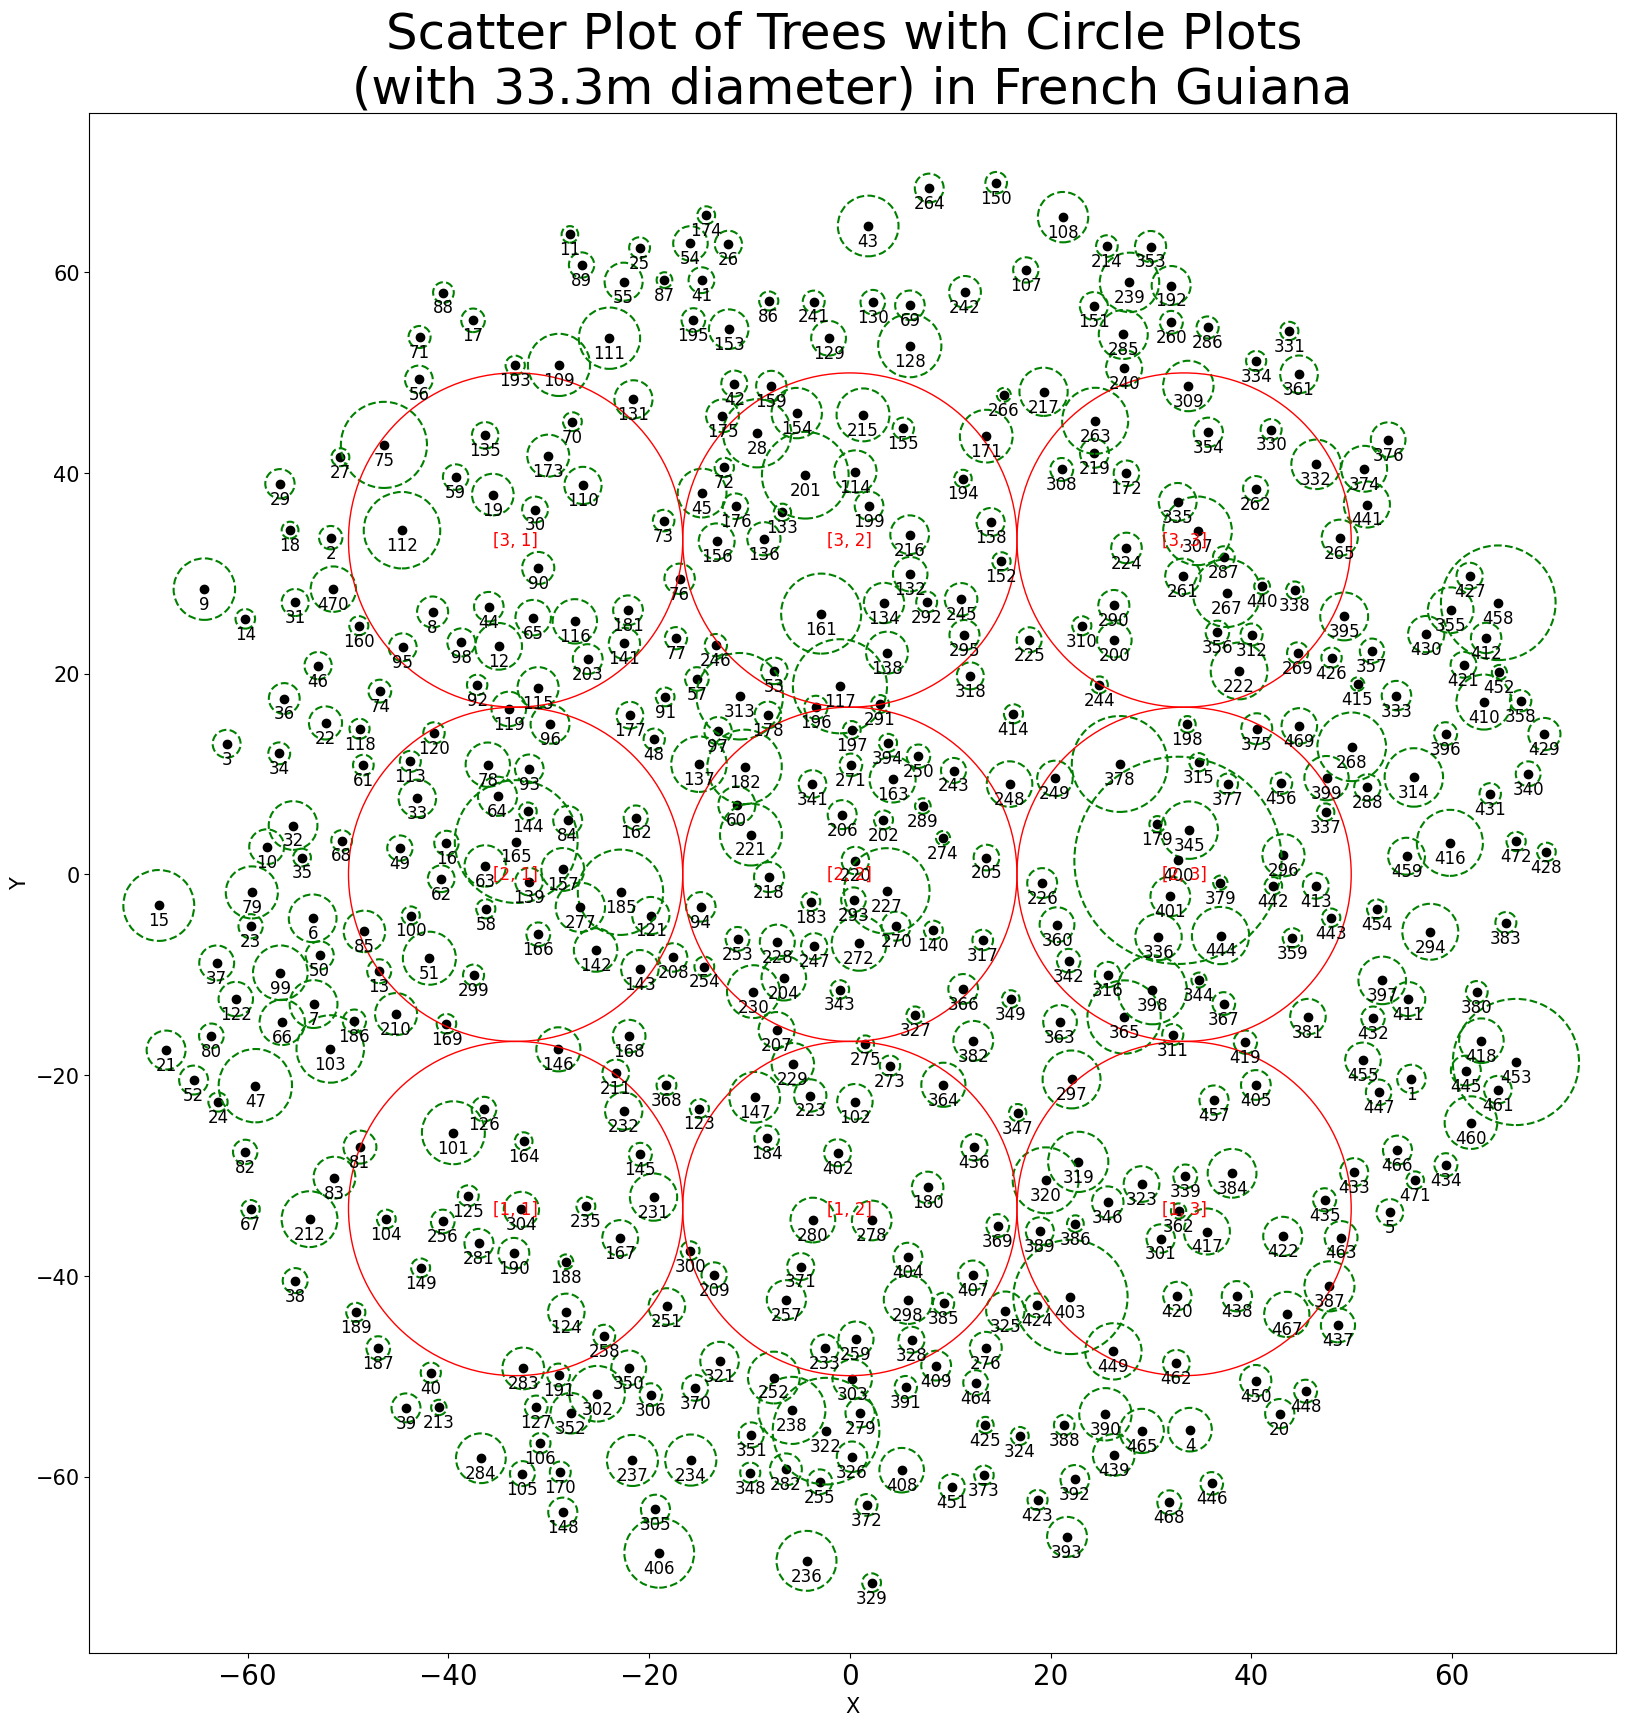

In [11]:
# Redirecting stdout to a text file
output_file = output_path + 'guiana_tree_search_output.txt'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

region = 'guiana'

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    guiana_tree_elements, guiana_x_values, guiana_y_values = load_matlab(region)
    guiana_tree_data, guiana_circle_indices = declare_tree_and_circle_data(guiana_tree_elements)

    total_trees = len(guiana_x_values)

    for tree_index, (x, y, tree_element) in enumerate(zip(guiana_x_values, guiana_y_values, guiana_tree_elements), start=1):

        print(f"Processing tree {tree_index} of {total_trees}")

        d2, crown_volume = calc_basic_tree_info(tree_index, tree_element, guiana_tree_data, guiana_x_values, guiana_y_values)

        find_tree_in_circle(d2, crown_volume, tree_index, x, y, guiana_circle_indices)

with open(output_file, "w") as file:
    file.write(captured_output.stdout)

plot_trees(guiana_x_values, guiana_y_values, guiana_tree_elements, region)

In [12]:
# Assuming tree_data is a dictionary containing tree information
for tree_index, tree_info in guiana_tree_data.items():
    x_coord = tree_info.get('x_coord')
    y_coord = tree_info.get('y_coord')
    if x_coord is not None and y_coord is not None:
        print(f"Tree {tree_index}: x = {x_coord}, y = {y_coord}")
    else:
        print(f"Tree {tree_index}: No coordinates found")

Tree Tree [1]: x = 55.95, y = -20.39
Tree Tree [2]: x = -51.72, y = 33.54
Tree Tree [3]: x = -62.09, y = 13.0
Tree Tree [4]: x = 33.89, y = -55.33
Tree Tree [5]: x = 53.8, y = -33.69
Tree Tree [6]: x = -53.52, y = -4.385
Tree Tree [7]: x = -53.43, y = -12.93
Tree Tree [8]: x = -41.57, y = 26.13
Tree Tree [9]: x = -64.31, y = 28.41
Tree Tree [10]: x = -58.1, y = 2.741
Tree Tree [11]: x = -27.89, y = 63.75
Tree Tree [12]: x = -34.99, y = 22.71
Tree Tree [13]: x = -46.89, y = -9.659
Tree Tree [14]: x = -60.23, y = 25.45
Tree Tree [15]: x = -68.85, y = -3.106
Tree Tree [16]: x = -40.19, y = 3.119
Tree Tree [17]: x = -37.54, y = 55.19
Tree Tree [18]: x = -55.77, y = 34.29
Tree Tree [19]: x = -35.57, y = 37.83
Tree Tree [20]: x = 42.83, y = -53.73
Tree Tree [21]: x = -68.12, y = -17.51
Tree Tree [22]: x = -52.24, y = 15.08
Tree Tree [23]: x = -59.7, y = -5.179
Tree Tree [24]: x = -62.95, y = -22.69
Tree Tree [25]: x = -20.95, y = 62.43
Tree Tree [26]: x = -12.1, y = 62.76
Tree Tree [27]: x =

In [13]:
# Redirecting stdout to a text file
output_file = output_path + 'guiana_gort_data_raw_output.txt'

# Use %%capture to capture output
with ipy_io.capture_output() as captured_output:

    print("California Redwood Results:\n")

    tree_sum = 0

    for circle_name, data in guiana_circle_indices.items():

        # Extract indices for the current circle
        tree_indices = data['tree_indices']

        get_circle_derived_values(data, tree_indices, guiana_tree_data)

        output_derived_data(circle_name, data)

    for circle_name, data in guiana_circle_indices.items():

        crown_percentages = data['crown_percentages']
        tree_percent_total = data['tree_percent_total']
        tree_sum = tree_sum + tree_percent_total

        print(f"Total Trees found in {circle_name}: {tree_percent_total}")

        # Print tree indices for each circle
        print(f"Tree indices: {tree_indices}")
        print("Percent of tree crown in circle: " + ", ".join([f"{percentage:.4f}" for percentage in crown_percentages]))

    print(f"\nTotal number of trees found in all circles: {tree_sum} out of {len(guiana_tree_elements)}")

with open(output_file, "w") as file:
    file.write(captured_output.stdout)

In [14]:
path_prefix = output_path + "guiana_output/"

output_tree_data(path_prefix, "tree_data.txt", guiana_tree_data)
output_circle_data(path_prefix, "circle_data.txt", guiana_circle_indices)
output_gort_inputs(path_prefix, guiana_circle_indices)